In [13]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics
%matplotlib inline
from itertools import chain
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import gower


from sklearn.cluster import MiniBatchKMeans, KMeans

from experiment.algorithms.cluster_prep import xBins, clusterStats, bestClusters, saveLabels, saveResults

# Load Fit Features

In [5]:
# data = pd.read_pickle('sorted_households.pkl') # Read pickle file
# # Read in only the sorted households, combine the dataframes with the sorted households features, perform clustering!!
# # Include the other finished bins that completed feature extraction

# df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
# df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
# df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
# df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
# df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
# df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# # Select all filtered households 
# df_50_150.loc[data['50_150']] 
# df_150_400.loc[data['150_400']]
# df_400_600.loc[data['400_600']] 
# df_600_1200.loc[data['600_1200']] 
# df_1200_2500.loc[data['1200_2500']] 

# # Combine all the data
# frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

# df = pd.DataFrame()
# df = df_50_150.append(frame)

In [6]:
# data = pd.read_pickle('sorted_households.pkl') # Read pickle file

# # Read in average monthly consumption data
# X = pd.read_csv('AMC_dataframe.csv', index_col=['ProfileID'])

# X.reset_index(inplace = True)
# # Extract household IDs
# household_ids = list(data.values())
# householdIDs =  [l.tolist() for l in household_ids]
# householdIDs = list(map(int, chain.from_iterable(householdIDs)))

# #Select rows based on condition 
# AMC_df = X[X['ProfileID'].isin(householdIDs)] 

# AMC_df.set_index(['ProfileID'], inplace=True)


# df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
# df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
# df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
# df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
# df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
# df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# # Select all filtered households 
# df_50_150.loc[data['50_150']] 
# df_150_400.loc[data['150_400']]
# df_400_600.loc[data['400_600']] 
# df_600_1200.loc[data['600_1200']] 
# df_1200_2500.loc[data['1200_2500']] 

# # Combine all the data
# frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

# df = pd.DataFrame()
# df = df_50_150.append(frame)

# #Select rows based on condition 
# df.reset_index(inplace=True)
# df = df[df['ProfileID'].isin(AMC_df.index.values)]

# df.set_index(['ProfileID'], inplace=True)


# #Select rows based on conditio
# AMC_df.reset_index(['ProfileID'], inplace=True)

# AMC_df = X[X['ProfileID'].isin(df.index.values)] 

# AMC_df.set_index(['ProfileID'], inplace=True)


# Load meta data features,fit features and AMC features

In [35]:
# data = pd.read_pickle('sorted_households.pkl') # Read pickle file

# Read in average monthly consumption data
X = pd.read_csv('AMC_dataframe.csv', index_col=['ProfileID'])
AMC_df = X.copy()

X.reset_index(inplace = True)
# # Extract household IDs
# household_ids = list(data.values())
# householdIDs =  [l.tolist() for l in household_ids]
# householdIDs = list(map(int, chain.from_iterable(householdIDs)))

#Select rows based on condition 
# AMC_df = X[X['ProfileID'].isin(householdIDs)] 

# AMC_df.set_index(['ProfileID'], inplace=True)


# Load fit features
df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Load the winter months features
# df_50_150 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
# # df_150_400 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
# df_400_600 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
# df_600_1200 = pd.read_csv('data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
# df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
# # df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/Winter_Weekdays/Winter_weekdays_FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
# df_50_150.loc[data['50_150']] 
# df_150_400.loc[data['150_400']]
# df_400_600.loc[data['400_600']] 
# df_600_1200.loc[data['600_1200']] 
# df_1200_2500.loc[data['1200_2500']] 

# Combine all the data
frame = [df_150_400,df_400_600,df_600_1200,df_1200_2500,df_2500_4000]#

df = pd.DataFrame()
df = df_50_150.append(frame)

#Select rows based on condition 
df.reset_index(inplace=True)

# Create dataframe with the geauss fit features
df = df[df['ProfileID'].isin(AMC_df.index.values)].copy()
df.set_index(['ProfileID'], inplace=True)
df = df.droplevel([0],axis = 1) # Drop level on multi column

# # Create dataframe with the winter weekday gauss fit features
# df_winter_weekdays = df[df['ProfileID'].isin(AMC_df.index.values)].copy()
# df_winter_weekdays.set_index(['ProfileID'], inplace=True)
# df_winter_weekdays = df_winter_weekdays.droplevel([0],axis = 1) # Drop level on multi column


#Select rows based on condition
AMC_df.reset_index(['ProfileID'], inplace=True)
AMC_df = X[X['ProfileID'].isin(df.index.values)] #df_winter_weekdays.index.values
AMC_df.set_index(['ProfileID'], inplace=True)

# Load Metadata
df1 = pd.read_csv(r"data/survey_data/delskv-1994-2014.csv",  header=[0], index_col = 0)
meta_df = df1[['floor_area', 'wall_material','total_adults', 'total_children','monthly_income','water_access','roof_material','years_electrified']] # Select relevant features
meta_df['total_residents'] = meta_df['total_adults'] + meta_df['total_children'] # Create total_residents feature

# Sort and filter datasets by ProfileIDs

In [36]:
# Drop all NaN values from dataframe
meta_df = meta_df.dropna()

# Filter out only households with Gauss Fit that completed a survey
households_ids1 = AMC_df.index.to_list()
meta_df_filtered = meta_df.loc[meta_df.index.isin(households_ids1),:]

# # Filter out only households that completed a survey from Gauss Fit
households_ids2 = meta_df_filtered.index.to_list()
AMC_df_filtered = AMC_df.loc[AMC_df.index.isin(households_ids2),:]

In [4]:
# ids_winters_months = pd.read_pickle(r'winter_months_ids') # Uncomment when using only winter weekdays data

# Encode non-numeric features

In [37]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
enc.fit(meta_df_filtered['roof_material'])
meta_df_filtered['roof_material_ENC'] = enc.transform(meta_df_filtered['roof_material'])

enc.fit(meta_df_filtered['water_access'])
meta_df_filtered['water_access_ENC'] = enc.transform(meta_df_filtered['water_access'])

enc.fit(meta_df_filtered['wall_material'])
meta_df_filtered['wall_material_ENC'] = enc.transform(meta_df_filtered['wall_material'])

meta_df_encoded = meta_df_filtered[['floor_area', 'monthly_income','total_residents','roof_material_ENC','water_access_ENC','wall_material_ENC', 'years_electrified']]
encoded_df = pd.merge(meta_df_encoded,AMC_df, left_index = True,right_index=True)

# Filter out households with missing winter months

In [38]:
encoded_df2 = pd.merge(encoded_df, df, left_index = True, right_index = True) # df_winter_weekdays

# encoded_df_filtered = encoded_df2.loc[encoded_df2.index.isin(ids_winters_months),:] # Uncomment when using winter weekdays dataframe

# Select either Morning or Afternoon Fit Features

In [12]:
# tod = 'Afternoon'
# amplitude = True


# if tod == 'Afternoon':
#     s1 = 'sigma3'
#     s2 = 'sigma4'   
#     if amplitude == True:
#         temp_df = df[tod][[s1,s2,'A2']] 
#     elif amplitude == False:
#         temp_df = df[tod][[s1,s2]] 

# elif tod == 'Morning':
#     s1 = 'sigma1'
#     s2 = 'sigma2'
#     if amplitude == True:
#         temp_df = df[tod][[s1,s2,'A1']] 
#     elif amplitude == False:
#         temp_df = df[tod][[s1,s2]]  

### Remove outliers in standard deviation values

In [6]:
df.drop(df['sigma1'].idxmax(), inplace= True) # Remove outlier in the dataframe
df.drop(df['sigma2'].idxmax(), inplace= True) # Remove outlier in the dataframe

# Standardize dataset

In [622]:
from sklearn.preprocessing import StandardScaler 
# create the scaler 
ss = StandardScaler() 
# take a subset of the dataframe you want to scale 
temp_df_subset = temp_df
# apply the scaler to the dataframe subset 
temp_df_scaled = ss.fit_transform(temp_df_subset)

scaled_df = pd.DataFrame(temp_df_scaled)

In [621]:
# Remove outliers
# temp_df = df['sigma3','sigma4']]
# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(temp_df))

# #only keep rows in dataframe with all z-scores less than absolute value of 3 
temp_df = temp_df[(z<3).all(axis=1)]

### Check the distribution of the mean times

In [18]:
# # Creating histogram
# bins = 10
# fig, ax = plt.subplots(figsize =(10, 7))
# ax.hist(df['Afternoon']['mu2'], bins = bins)

# ax.set_title("Histogram of Afternoon ToPs")
# ax.set_xlabel("Time of Peak")
# ax.set_ylabel("Count")
# # Show plot
# plt.show()

# # Save Fig
# fig.savefig('Histogram_Afternoon_ToPs.png', dpi=72, bbox_inches='tight')

# Create scatter plots of the sigma values

### 2D plot

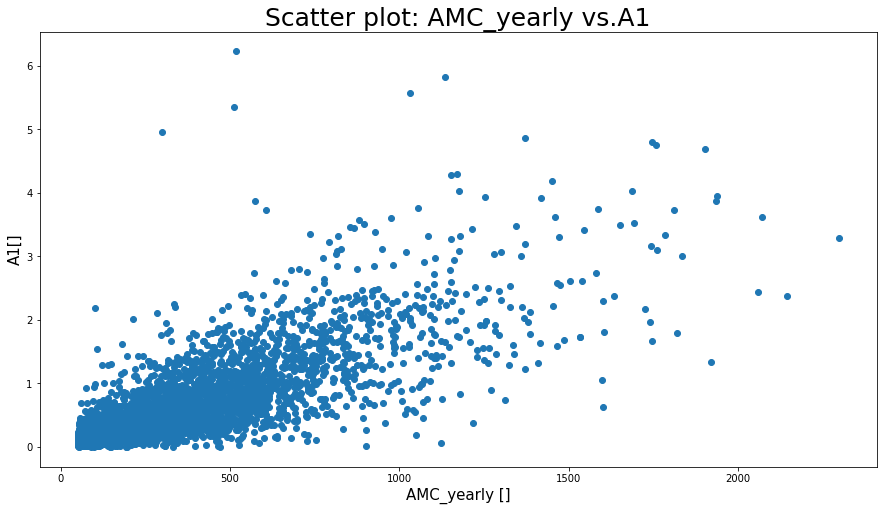

In [49]:
# s1 = 'sigma3'
# s2 = 'sigma4'
# x = temp_df[s1]
# y = temp_df[s2]
# scale = 'log'
scale = ''

feature1 = 'AMC_yearly'
feature2 = 'A1'

x = encoded_df2[feature1]
y = encoded_df2[feature2]*230/1000

x_label = feature1
y_label = feature2

fig, ax = plt.subplots(figsize =(15, 8))

plt.scatter(x, y)
plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + x_label + ' vs.' + y_label)
ax.set_ylabel(y_label + "[" + scale + "]")
ax.set_xlabel(x_label + " [" + scale +"]")
# ax.set_yscale(scale)
# ax.set_xscale(scale)
plt.show()

# # Save Fig
# fig.savefig('SP_Afternoon_' + x_label + 'vs' + y_label + '.png', dpi=72, bbox_inches='tight')

### 3D plot

In [172]:
# # importing required libraries
# from mpl_toolkits.mplot3d import Axes3D

# # for creating a responsive plot
# %matplotlib widget

# X = pd.DataFrame()
# X = encoded_df_filtered.copy()
# # Create 3-D Scatter plot
# ## Creating Dataset
# z = X['A1']
# y = X['sigma2']
# x = X['sigma1']

# # Creating figure
# fig = plt.figure(figsize = (10, 7))
# ax = Axes3D(fig)
  

# # Creating plot
# ax.scatter(x, y, z)
# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('Sigma1')
# ax.set_ylabel('Sigma2')
# ax.set_zlabel('Amplitude')

# # show plot
# plt.show()

# # fig, axes = plt.subplots(1, 1, figsize=(16,8))
# # # axes[0].scatter(df[0], df[1], c=df['target'])
# # axes.scatter( c=X['k_means'], cmap=plt.cm.Set1)
# # axes[0].set_title('Actual', fontsize=18)
# # axes.set_title('K_Means', fontsize=18)

In [10]:
def kmeans(X, range_n_clusters, top_lbls=10, experiment_name = False):
    """
    This function applies the MiniBatchKmeans algorithm from sklearn on inputs X for range_n_clusters.
    If preprossing = True, X is normalised with sklearn.preprocessing.normalize()
    Returns cluster stats, cluster centroids and cluster labels.
    """
    # Transform dataframe to array
    temp_df = X['Morning']
    A = temp_df.iloc[:,:4].to_numpy()

    # Create dataframes for cluster results
    centroids = pd.DataFrame()
    stats = pd.DataFrame() 
    cluster_lbls = pd.DataFrame()

    dim = 0 #set dim to 0 to match SOM formating  
    cluster_lbls_dim = {}
    stats_dim = pd.DataFrame()
    
    for n_clust in range_n_clusters:
        
        clusterer = KMeans(n_clusters=n_clust, random_state=10)
                    
        #train clustering algorithm
        tic = time.time()        
        clusterer.fit(A)
        cluster_labels = clusterer.predict(A)
        toc = time.time()
        
        ## Calculate scores
        cluster_stats = clusterStats({}, n_clust, A, cluster_labels, 
                                         transform = None,
                                        tic = tic, toc = toc)        # preprocessing = preprocessing,
        cluster_centroids = clusterer.cluster_centers_ 
        
        eval_results, centroid_results = saveResults(experiment_name, cluster_stats,
                                                        cluster_centroids, dim)
        
        stats_dim = stats_dim.append(eval_results)
        centroids = centroids.append(centroid_results)

        cluster_lbls_dim[n_clust] = cluster_labels

    #outside n_clust loop
    best_clusters, best_stats = bestClusters(cluster_lbls_dim, stats_dim, top_lbls)
    cluster_lbls = pd.concat([cluster_lbls, best_clusters], axis=1)
    stats = pd.concat([stats, best_stats], axis=0)
    
    stats.reset_index(drop=True, inplace=True)


    saveLabels(cluster_lbls, stats)
    
    return stats, centroids, cluster_lbls        

# Choosing optimal number of clusters: Elbow Method

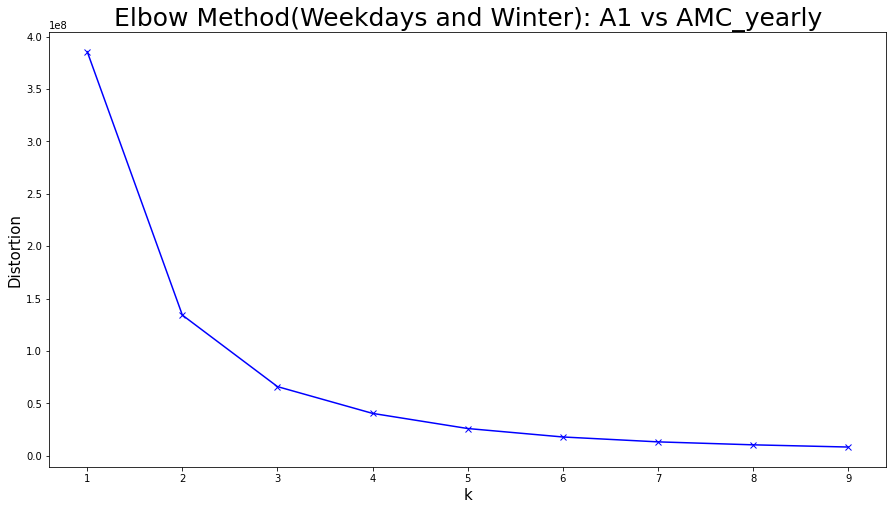

In [50]:
feature1 = 'A1'
feature2 = 'AMC_yearly'

title_label = feature1 + " vs " + feature2

X = encoded_df2[[feature1,feature2]].copy() # Comment out when removing outliers with z-score

# Create dataset
# temp_df = temp_df['Morning']
A = X.to_numpy()

# x = AMC_df['AMC_winter']
# y = temp_df['A1']

# Calculate distortions
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(A)
    distortions.append(kmeanModel.inertia_)

fig, ax = plt.subplots(figsize =(15, 8))

# Create Elbow Plot
# plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('Elbow Method(Weekdays and Winter): ' + title_label)

plt.show()

# # Save Fig
# fig.savefig('EM_Morning_' + title_label + '.png', dpi=72, bbox_inches='tight')

## Determine the goodness of fit of the clustering method: Silhouette Coefficient

In [185]:
kmeans_df = pd.DataFrame(columns = ['Features', 'n_clusters', 'Silhouette Score'])

In [207]:
import plotly.graph_objects as go
# Select Features
s1 = 'sigma3'
s2 = 'sigma4'

# X[s1] = np.log(X[s1])
# X[s2] = np.log(X[s2])

A = encoded_df2[[s1,s2]].copy()
features = s1 + ' vs ' + s2

SC = []
n_cluster = []
for i in range(2,10):
    KMean= KMeans(n_clusters=i)
    KMean.fit(A)
    label=KMean.predict(A)

    n_cluster.append(i)
    SC.append(f'{silhouette_score(A, label):.3f}')
    # Determine the Silhouette Score
    print(f'Silhouette Score(n={i}): {silhouette_score(A, label)}')

df2 = pd.DataFrame({'Features': features, 'n_clusters': n_cluster,'Silhouette Score': SC})

#add new row to end of DataFrame
kmeans_df = kmeans_df.append(df2, ignore_index = True)

# fig = go.Figure(data=[go.Table(  columnwidth = [12,10,15],header=dict(values=['Features','n_clusters', 'Silhouette Score']),
#                  cells=dict(values=[features,n_cluster, SC]))
#                      ])    

# fig.update_layout(width=600, height=500)

# fig.show()

Silhouette Score(n=2): 0.39980593762335714
Silhouette Score(n=3): 0.33808493829542124
Silhouette Score(n=4): 0.335853761703924
Silhouette Score(n=5): 0.3270453357641187
Silhouette Score(n=6): 0.33158018299525105
Silhouette Score(n=7): 0.33156352050089344
Silhouette Score(n=8): 0.3317893092189828
Silhouette Score(n=9): 0.32877311079295457


### Save results of KMeans CLustering Silhouette Scores

In [210]:
# kmeans_df.reset_index('Features', inplace = True)

kmeans_top_results = kmeans_df.groupby(['Features'])['Silhouette Score'].max()
kmeans_top_results_df = kmeans_top_results.to_frame()

kmeans_top_results_df.reset_index(inplace=True)

import plotly.figure_factory as ff

kmeans_top_results_df
fig = ff.create_table(kmeans_top_results_df)
fig.show()
# # Save Fig
fig.write_image('KMeans_SC_top_results.png')

# Plot K-means cluster results

In [211]:
encoded_df_filtered = encoded_df2[encoded_df2['monthly_income'] != 0.0].copy()

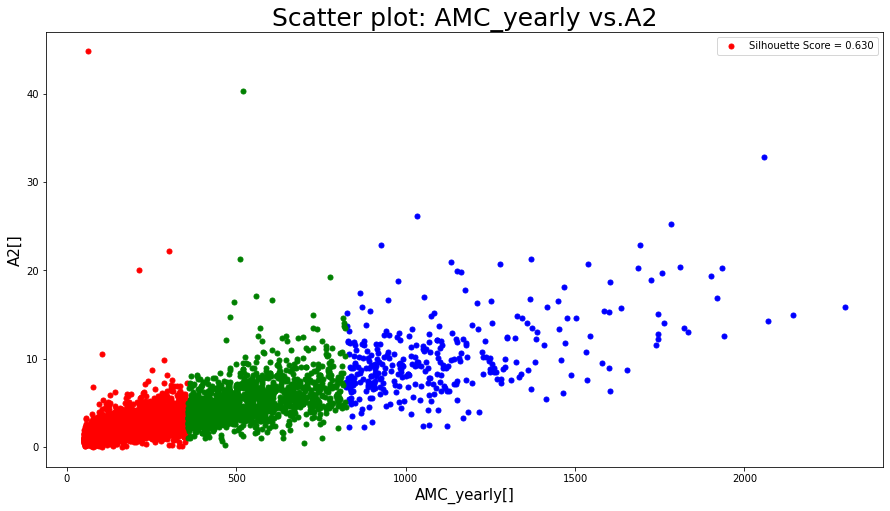

In [57]:
from sklearn.cluster import KMeans
import numpy as np

X = pd.DataFrame()
# X = encoded_df_filtered.copy()

# scale = 'log'
scale = ''

s2 = 'A2'
s1 = 'AMC_yearly'
X = encoded_df2[[s1,s2]].copy()
# X[s1] = np.log(X[s1])
# X[s2] = np.log(X[s2])


# k means
kmeans = KMeans(n_clusters=3, random_state=10)
y_kmeans = kmeans.fit_predict(X)
labels = kmeans.fit(X).labels_
# get centroids
centroids = kmeans.cluster_centers_
SC = silhouette_score(X, labels)
# print()

fig, ax = plt.subplots(figsize =(15, 8))

plt.scatter(X[y_kmeans==0][s1], X[y_kmeans==0][s2], s=25, c='red', label ='Cluster 1')
plt.scatter(X[y_kmeans==1][s1], X[y_kmeans==1][s2], s=25, c='blue', label ='Cluster 2')
plt.scatter(X[y_kmeans==2][s1], X[y_kmeans==2][s2], s=25, c='green', label ='Cluster 3')
plt.scatter(X[y_kmeans==3][s1], X[y_kmeans==3][s2], s=25, c='cyan', label ='Cluster 4')
# plt.scatter(X[y_kmeans==4]['sigma1'], X[y_kmeans==4]['sigma2'], s=100, c='magenta', label ='Cluster 5')
# plt.scatter(X[y_kmeans==5]['sigma1'], X[y_kmeans==5]['sigma2'], s=100, c='purple', label ='Cluster 5')
plt.legend([f'Silhouette Score = {SC:.3f}'])
plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s2 + '[' + scale +']')
ax.set_xlabel(s1 + '[' + scale +']')
# ax.set_yscale('log')
# ax.set_xscale("log")
plt.show()

# # Save Fig
# fig.savefig('KMeans_' + scale +'_' + s1 + '_vs_' + s2 + '.png', dpi=72, bbox_inches='tight')
# fig.savefig('KM_(nww)'+s1+'_vs_'+s2+'.png', dpi=72, bbox_inches='tight')


In [52]:
AMC_Fit_df.to_csv('AMC_Fit_kmeans_dataframe.csv', index = True)

In [50]:
AMC_Fit_df.set_index(['ProfileID'], inplace = True)

## Create labeled dataframe

# DBSCAN clustering

In [39]:
# Import it!
from dbscan2 import dbscan2
from sklearn.datasets import make_moons

In [41]:
# Create dataset
# df = pd.read_csv('FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
temp_df = data_clean['Morning']
A = temp_df.iloc[:,[0,1]].to_numpy()

In [42]:
dbscan_df = pd.DataFrame(columns = ['eps', 'n_clusters', 'Silhouette Coefficient'])

for eps in np.arange(0.1,1,0.05):
    min_samples = 3

    # instantiating DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # fitting model
    model = dbscan.fit(A)
    labels = model.labels_

    # identify core samples
    core_samples = np.zeros_like(labels, dtype=bool)
    core_samples[dbscan.core_sample_indices_] = True
    # print(core_samples)

    # declare the number of clusters
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
    list_dbscan = [[eps,n_clusters_, metrics.silhouette_score(A, labels)]]
    dbscan_df = dbscan_df.append(pd.DataFrame(list_dbscan, columns =  ['eps', 'n_clusters', 'Silhouette Coefficient']), ignore_index = True)        

    # print(f'Number of clusters = {n_clusters_}')
    # print(f"eps = {eps}, min_smaples = {min_samples}")
    # print("Silhoette Coefficient: %0.3f" % metrics.silhouette_score(A, labels))

In [44]:
dbscan_df[dbscan_df['Silhouette Coefficient'] == dbscan_df[dbscan_df['n_clusters'] >= 2]['Silhouette Coefficient'].max()]

,eps,n_clusters,Silhouette Coefficient
17,0.95,2,0.820456


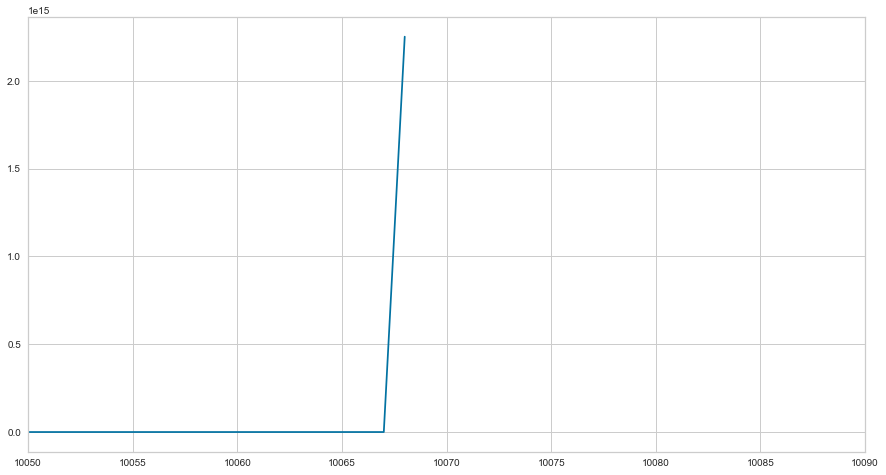

In [52]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(A) # fitting the data to the object
distances,indices=nbrs.kneighbors(A) # finding the nearest neighbours
%matplotlib inline
 
fig = plt.figure(figsize=(15,8))

# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.xlim(10050,10090)
# plt.xticks(np.arange(9300,9400,5))
# plt.yticks(np.arange(0,1,0.05))
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

# Gowers Distance

In [53]:
from sklearn.neighbors import DistanceMetric
import gower

In [408]:

# from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
# dm = gower.gower_matrix(morning_DF)
# Zd = linkage(dm)

# cld = fcluster(Zd, 3, criterion='maxclust')
# cld

# dendrogram(Zd) 

# DBSCAN with Gowers Distance

### 2-dimensional clustering, sigma1 & sigma2

In [464]:
X = pd.DataFrame()
X = temp_df.copy()

s1 = 'sigma1'
s2 = 'sigma2'

#normalize values in every column
# X = (X-X.min())/ (X.max() - X.min())

X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])

# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.042, 
                        min_samples=3, 
                        metric="precomputed")

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
X["cluster"] = dbscan_cluster.labels_

len(X['cluster'].unique())

5

# Plot DBSCAN clusters Gowers Distance

### Log values first

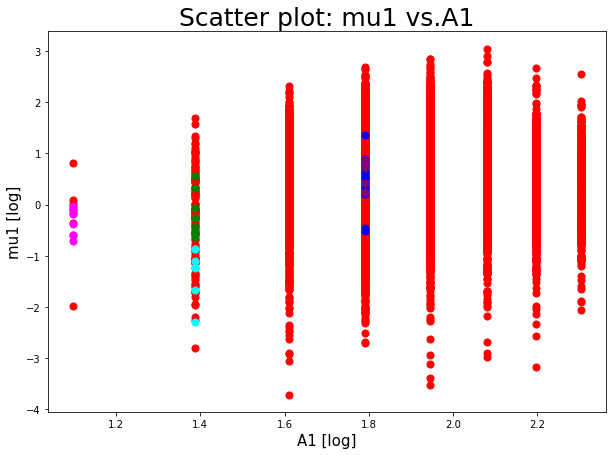

In [34]:
X = pd.DataFrame()
X = df.copy()

s1 = 'mu1'
s2 = 'A1'

scale = 'log'
# scale = ''

X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])
# # DBSCAN
# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.021, 
                        min_samples=6, 
                        metric="precomputed")

# Fitting the clustering algorithm
y_dbscan = dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
# df['afternoon_sigma_labels'] = dbscan_cluster.labels_
y_dbscan_labels = dbscan_cluster.labels_
# k means
# kmeans = KMeans(n_clusters=4, random_state=10)
# y_kmeans = kmeans.fit_predict(X)
# get centroids
# centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(X[y_dbscan_labels==0][s1], X[y_dbscan_labels==0][s2], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_dbscan_labels==1][s1], X[y_dbscan_labels==1][s2], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_dbscan_labels==2][s1], X[y_dbscan_labels==2][s2], s=50, c='green', label ='Cluster 3')
plt.scatter(X[y_dbscan_labels==3][s1], X[y_dbscan_labels==3][s2], s=50, c='cyan', label ='Cluster 4')
plt.scatter(X[y_dbscan_labels==4][s1], X[y_dbscan_labels==4][s2], s=50, c='magenta', label ='Cluster 5')
plt.scatter(X[y_dbscan_labels==5][s1], X[y_dbscan_labels==5][s2], s=50, c='purple', label ='Cluster 5')

plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + " [" + scale + "]")
ax.set_xlabel(s2 + " [" + scale + "]")
# ax.set_yscale('log')
# ax.set_xscale("log")
plt.show()
# # Save Fig
# fig.savefig('Scatter_plot_Morning_DBSCAN_'+ scale + '.png', dpi=72, bbox_inches='tight')

### Normalize values first

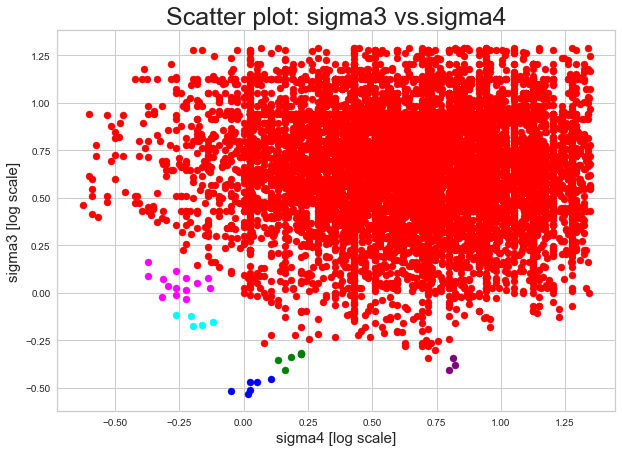

In [324]:


X = pd.DataFrame()
X = temp_df.copy()

s1 = 'sigma3'
s2 = 'sigma4'

#normalize values in every column
# X = (X-X.min())/ (X.max() - X.min())
X[s1] = np.log(X[s1])
X[s2] = np.log(X[s2])

# DBSCAN
# Compute distance matrix
distance_matrix = gower.gower_matrix(X)

# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.021, 
                        min_samples=3, 
                        metric="precomputed")

# Fitting the clustering algorithm
y_dbscan = dbscan_cluster.fit(distance_matrix)

# Adding the results to a new column in the dataframe
y_dbscan_labels = dbscan_cluster.labels_

# k means
# kmeans = KMeans(n_clusters=4, random_state=10)
# y_kmeans = kmeans.fit_predict(X)
# get centroids
# centroids = kmeans.cluster_centers_

fig, ax = plt.subplots(figsize =(10, 7))

plt.scatter(X[y_dbscan_labels==0][s1], X[y_dbscan_labels==0][s2], s=50, c='red', label ='Cluster 1')
plt.scatter(X[y_dbscan_labels==1][s1], X[y_dbscan_labels==1][s2], s=50, c='blue', label ='Cluster 2')
plt.scatter(X[y_dbscan_labels==2][s1], X[y_dbscan_labels==2][s2], s=50, c='green', label ='Cluster 3')
plt.scatter(X[y_dbscan_labels==3][s1], X[y_dbscan_labels==3][s2], s=50, c='cyan', label ='Cluster 4')
plt.scatter(X[y_dbscan_labels==4][s1], X[y_dbscan_labels==4][s2], s=50, c='magenta', label ='Cluster 5')
plt.scatter(X[y_dbscan_labels==5][s1], X[y_dbscan_labels==5][s2], s=50, c='purple', label ='Cluster 5')

plt.rc('axes', titlesize=25) 
plt.rc('axes', labelsize=15)
plt.title("Scatter plot: " + s1 + ' vs.' + s2)
ax.set_ylabel(s1 + " [log scale]")
ax.set_xlabel(s2 + " [log scale]")
# ax.set_yscale('log')
# ax.set_xscale("log")
plt.show()
# # Save Fig
# fig.savefig('Scatter_plot_Afternoon_DBSCAN_log_scale.png', dpi=72, bbox_inches='tight')

In [246]:
# morning_DF1,morning_DF2,morning_DF3,morning_DF4,morning_DF5,morning_DF6,morning_DF7,morning_DF8,morning_DF9 = [x for _, x in morning_DF.groupby('mu1')]

In [247]:

# distance_matrix = gower.gower_matrix(morning_DF1)

# # Configuring the parameters of the clustering algorithm
# dbscan_cluster = DBSCAN(eps=0.036, 
#                         min_samples=3, 
#                         metric="precomputed")

# # Fitting the clustering algorithm
# dbscan_cluster.fit(distance_matrix)

# # Adding the results to a new column in the dataframe
# morning_DF1["cluster"] = dbscan_cluster.labels_

# len(morning_DF1['cluster'].unique())

# Clustering with OPTICS

Estimated no. of clusters: 14
Estimated no. of noise points: 662


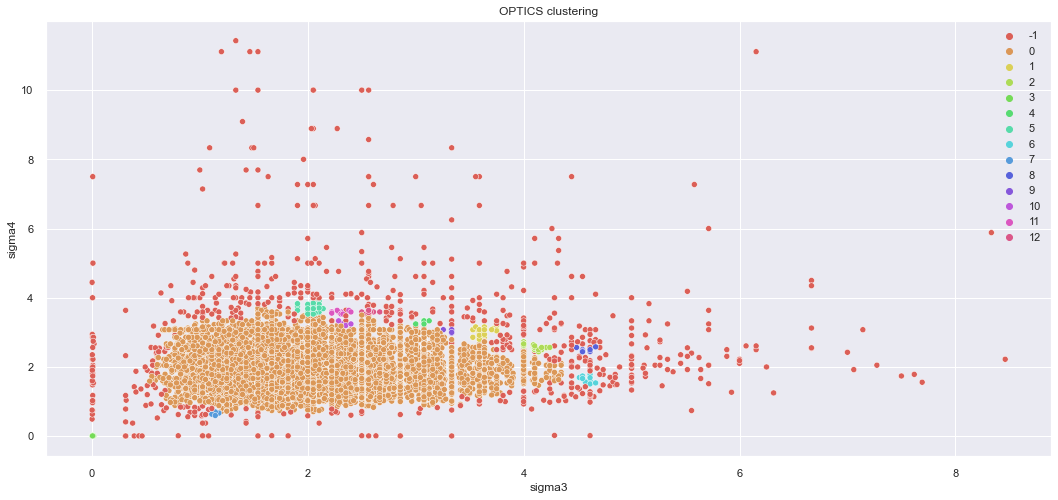

In [599]:
from sklearn.datasets import make_blobs
from sklearn.cluster import OPTICS
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# # Configuration options
# num_samples_total = 1000
# cluster_centers = [(3,3), (7,7)]
# num_classes = len(cluster_centers)
epsilon = 0.1
min_samples = 8
cluster_method = 'dbscan'
metric = 'minkowski'

# Generate data

X = temp_df.copy()
scale = ''
# s1 = 'sigma1'
# s2 = 'sigma2'

# X[s1] = np.log(X[s1])
# X[s2] = np.log(X[s2])

# X = X.to_numpy()

# Compute OPTICS
db = OPTICS(max_eps=epsilon, min_samples=min_samples, cluster_method=cluster_method, metric=metric).fit(X)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

# Generate scatter plot for training data
# fig, ax = plt.figure(figsize = (30,16))
plot = sns.scatterplot(x=s1,y=s2,hue = labels, palette=sns.color_palette("hls",no_clusters),data=X)
sns.set(rc={"figure.figsize":(18, 8)}) #width=3, #height=4


plt.title(f'OPTICS clustering')
plt.xlabel(s1)
plt.ylabel(s2)
# plot.axes.set_xscale('log')
# plot.axes.set_yscale('log')
plt.show()

# Save PNG
fig = plot.get_figure()
fig.savefig('Scatter_plot_' + tod + '_OPTICS.png', dpi=72, bbox_inches='tight')

# Standardize dataset